<a href="https://colab.research.google.com/github/JinMizar/ds3001_final_project/blob/main/result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! git clone https://github.com/JinMizar/ds3001_final_project.git

Cloning into 'ds3001_final_project'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 75 (delta 34), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (75/75), 1.01 MiB | 6.35 MiB/s, done.
Resolving deltas: 100% (34/34), done.


# Result: DS3001 Final Project
**Team Members**: Jinhong Zhao, Tong Zhou, Hanna Svenson

---
### Prediction Question
**Which chemical properties of Portuguese red wine are most predictive of high-quality wine (scores 7 and 8)?**

Our analysis aims to provide actionable insights for wine producers and consumers by identifying the chemical properties most strongly associated with high-quality wines and evaluating the predictive accuracy of our classification model.


In [3]:
#Necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV


In [4]:
df = pd.read_csv('ds3001_final_project/data/WineQT.csv')

#we focus on predicting the best wines (scores 7 and 8 or just the 8's) instead of trying to predict 3 categories.
def categorize_quality(rating):
    return 1 if rating >= 7 else 0  #1 if High-quality

df['quality_binary'] = df['quality'].apply(categorize_quality)

X = df.drop(columns=['quality', 'quality_binary'])
y = df['quality_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features for PCA and Model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Data Preparation
The dataset includes chemical properties of Portuguese red wines, and wines were classified into two categories: high-quality (scores ≥ 7) and not high-quality (scores < 7). Features were standardized using `StandardScaler` to ensure comparability for dimensionality reduction and modeling.


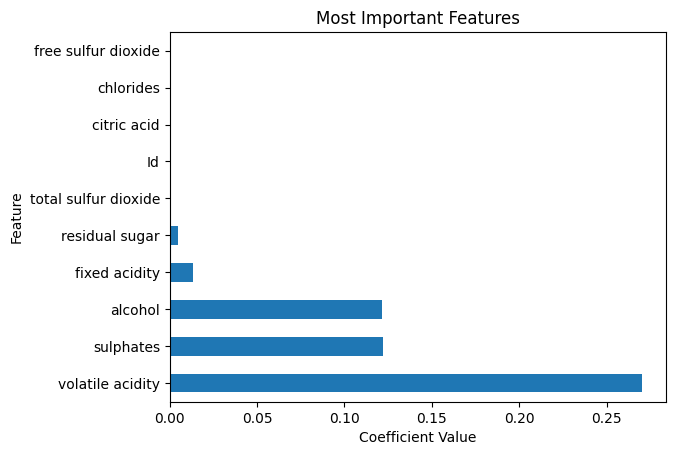

In [5]:
lasso = LassoCV(cv=5).fit(X_train, y_train)
coef = pd.Series(lasso.coef_, index=X.columns)

# Plot top features
top_features = coef.abs().sort_values(ascending=False).head(10)
top_features.plot(kind='barh')
plt.title("Most Important Features")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()

As mention from the pre-analysis, We consider using Lasso regression in the later analysis to minimize the impact of correlated variables and identify the most important chemical properties.

Using the 5 relevant features in the Lasso regression, we will create boxplots to see the distribution of these features between the two different qualities.

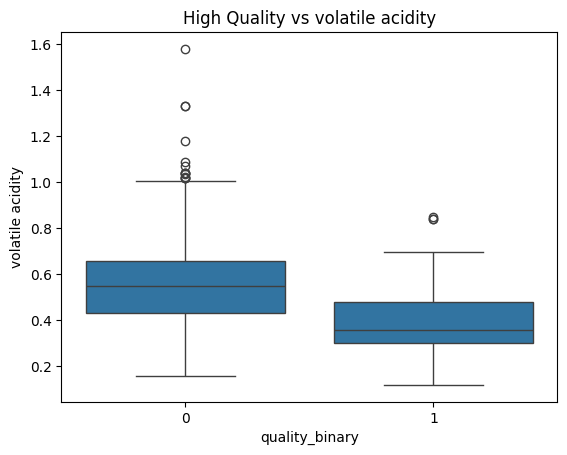

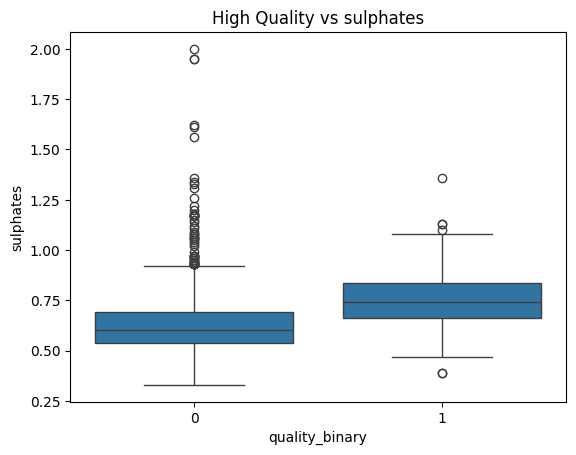

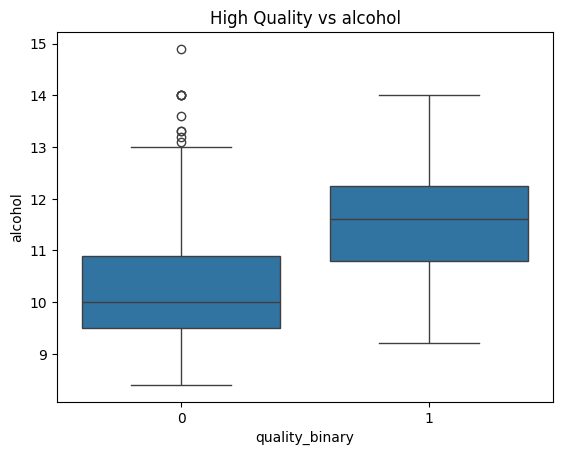

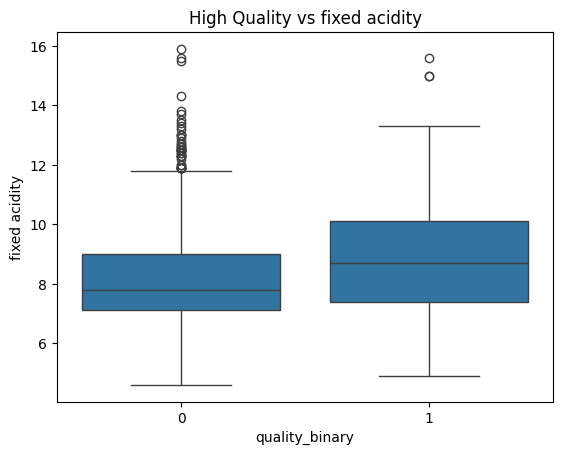

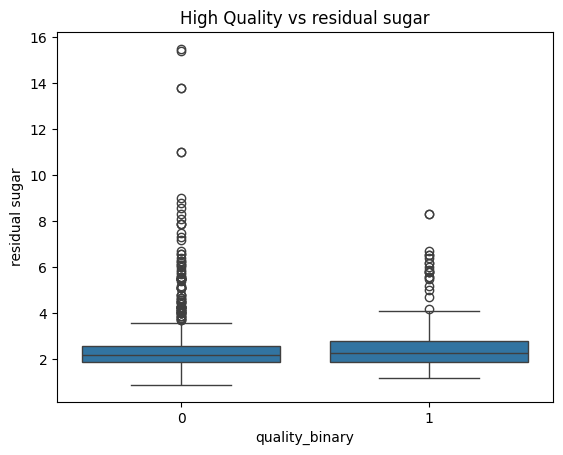

In [6]:
important_features=['volatile acidity', 'sulphates', 'alcohol', 'fixed acidity', 'residual sugar']
for feature in important_features:  # Replace with your list of top variables
    sns.boxplot(x="quality_binary", y=feature, data=df)
    plt.title(f"High Quality vs {feature}")
    plt.show()

Above, we see box plots created for the top features from our Lasso analysis with non-zero values. The boxplots allow us to further investigate the relationships between these variables and wine quality. To determine if the selected variable is actually relevant for distinguishing between high and low quality wines, we would expect to see noticable difference in the medians and minimal overlap between the IQRs of the two groups. We see these features more in the first 3 variables (volatile acidity, sulfates, and alcohol), but less so in the last 2 variables (fixed acidity and residual sugar). We will keep this in mind for our next analyses.

## Decission Tree Classification Using Features Identified by Lasso


In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

X_train_relevant = X_train[important_features]
X_test_relevant = X_test[important_features]

# Train a single decision tree
tree_model = DecisionTreeClassifier(max_depth=4, random_state=100)  # Adjust max_depth for complexity
tree_model.fit(X_train_relevant, y_train)

# Evaluate the model
y_pred_tree = tree_model.predict(X_test_relevant)
y_prob_tree = tree_model.predict_proba(X_test_relevant)[:, 1]

print("Single Decision Tree - Classification Report:")
print(classification_report(y_test, y_pred_tree))

print("Single Decision Tree - AUC-ROC:", roc_auc_score(y_test, y_prob_tree))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_tree))



Single Decision Tree - Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       201
           1       0.50      0.36      0.42        28

    accuracy                           0.88       229
   macro avg       0.71      0.65      0.67       229
weighted avg       0.86      0.88      0.87       229

Single Decision Tree - AUC-ROC: 0.8440831556503199
Confusion Matrix:
[[191  10]
 [ 18  10]]


In [35]:

X_train_relevant4 = X_train[important_features].drop(columns = ['residual sugar'])
X_test_relevant4 = X_test[important_features].drop(columns = ['residual sugar'])


# Train a single decision tree
tree_model4 = DecisionTreeClassifier(max_depth=4, random_state=100)  # Adjust max_depth for complexity
tree_model4.fit(X_train_relevant4, y_train)

# Evaluate the model
y_pred_tree4 = tree_model4.predict(X_test_relevant4)
y_prob_tree4 = tree_model4.predict_proba(X_test_relevant4)[:, 1]

print("Single Decision Tree - Classification Report:")
print(classification_report(y_test, y_pred_tree4))

print("Single Decision Tree - AUC-ROC:", roc_auc_score(y_test, y_prob_tree4))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_tree4))

Single Decision Tree - Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       201
           1       0.50      0.43      0.46        28

    accuracy                           0.88       229
   macro avg       0.71      0.68      0.70       229
weighted avg       0.87      0.88      0.87       229

Single Decision Tree - AUC-ROC: 0.8748223169864962
Confusion Matrix:
[[189  12]
 [ 16  12]]


In [30]:

X_train_relevant3 = X_train[important_features].drop(columns = ['residual sugar', 'fixed acidity'])
X_test_relevant3 = X_test[important_features].drop(columns = ['residual sugar', 'fixed acidity'])

# Train a single decision tree
tree_model3 = DecisionTreeClassifier(max_depth=4, random_state=100)  # Adjust max_depth for complexity
tree_model3.fit(X_train_relevant3, y_train)

# Evaluate the model
y_pred_tree3 = tree_model3.predict(X_test_relevant3)
y_prob_tree3 = tree_model3.predict_proba(X_test_relevant3)[:, 1]

print("Single Decision Tree - Classification Report:")
print(classification_report(y_test, y_pred_tree3))

print("Single Decision Tree - AUC-ROC:", roc_auc_score(y_test, y_prob_tree3))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_tree3))

Single Decision Tree - Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       201
           1       0.50      0.43      0.46        28

    accuracy                           0.88       229
   macro avg       0.71      0.68      0.70       229
weighted avg       0.87      0.88      0.87       229

Single Decision Tree - AUC-ROC: 0.8441719971570718
Confusion Matrix:
[[189  12]
 [ 16  12]]


In the trees above, we compared the performance of classification trees using either all 5, 4, or 3 of the relevant variables determined by Lasso. We see that the model using 4 features has a higher AUC-ROC score than the others, and has 2 fewer false positives identified for our high quality wines. We will now use that tree and visualise the rules.

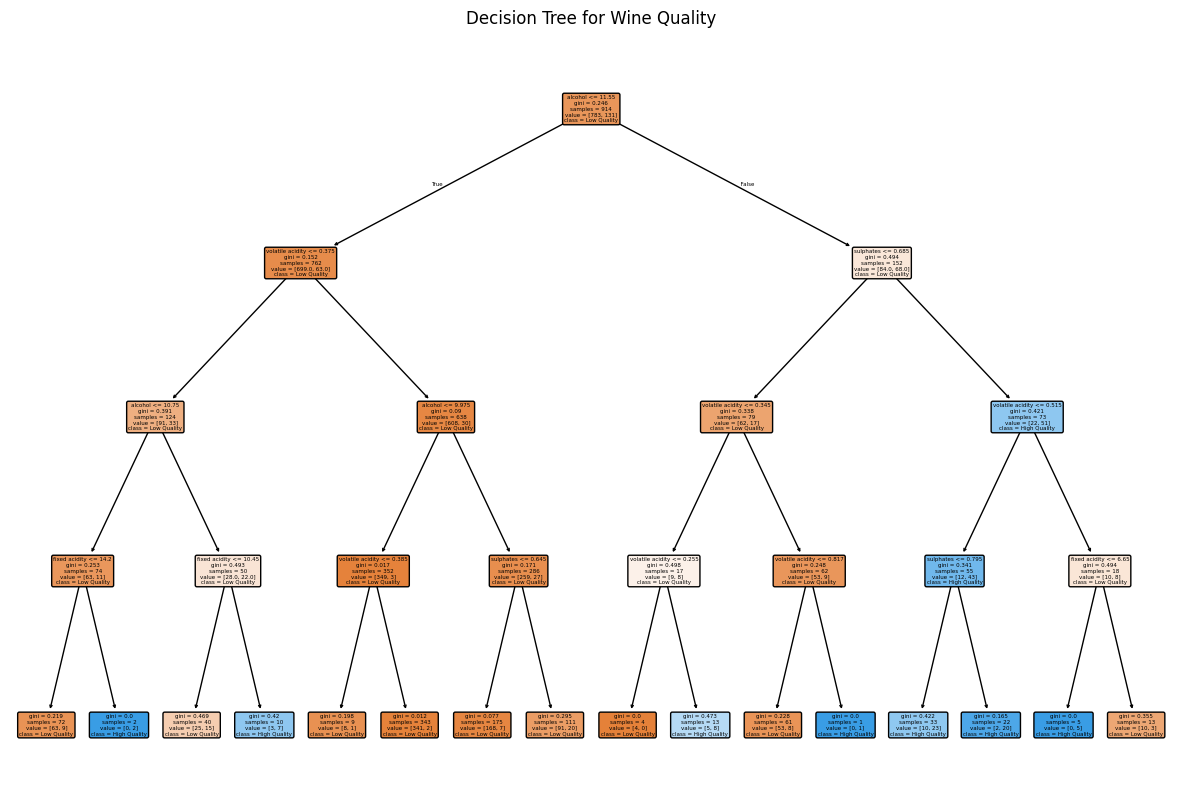

In [31]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plot_tree(
    tree_model4,
    feature_names=['volatile acidity', 'sulphates', 'alcohol', 'fixed acidity'],
    class_names=["Low Quality", "High Quality"],
    filled=True,
    rounded=True
)
plt.title("Decision Tree for Wine Quality")
plt.show()


Even though this is the tree that provided the best performing metrics, there are a significant number of nodes and levels to go through for someone to deterime a good wine from a bad one. Although this approach provides good interperetability, having too many decisions to go through will be inconvenient for anyone to sort through. Further approaches will be explored to gain more insight.

## Logistic Regression Performance (Baseline)

In [ ]:
#Train a Logistic Regression model
log_reg = LogisticRegression(max_iter=500).fit(X_train_scaled, y_train)

y_hat_train = log_reg.predict(X_train_scaled)
y_hat_test = log_reg.predict(X_test_scaled)

print("\nClassification Report:\n", classification_report(y_test, y_hat_test))



Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.94       201
           1       0.60      0.54      0.57        28

    accuracy                           0.90       229
   macro avg       0.77      0.74      0.75       229
weighted avg       0.90      0.90      0.90       229



An overall accuracy of 90% was achieved in the Logistic Regression model, where the model was able to classify the majority class (non-high-quality wines) with high precision (94%) and recall (95%). However, with the evaluation of the classification model on the minority class (high-quality wines), there was still a moderate performance with a precision of 60%, recall of 54%, and F1-score of 57%. The macro averageF1-score was 75%, which indicates the imbalanced nature of our class distribution. Although the model is quite good at predicting wines that are not of high quality, its accuracy when predicting high quality wines could be improved, and it would be beneficial to balance the two classes and improve feature selection.

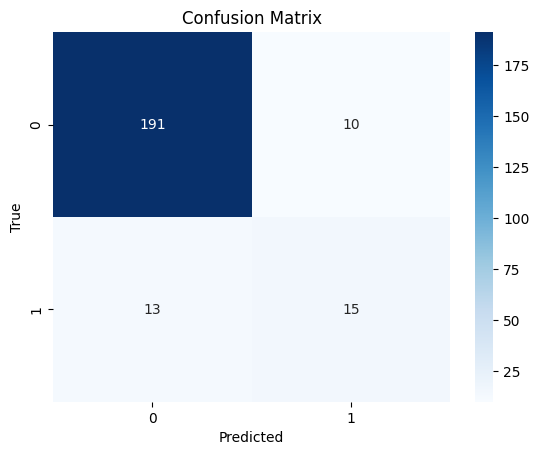

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_hat_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Here is the confusion matrix for the Baseline Logistic Regression model and we can clearly observe the class imbalance problem. The model identifies the majority class (non-high quality wines) well, with 191 true negatives and only 10 false positives. But here it has a hard time with the minority class (which is high-quality wines), correctly predicting 15 true positives, and mistaking 13 high-quality wines as non-high-quality (false negatives). This imbalance in performance underscores the need for strategies to improve recall for high-quality wines, such as addressing class imbalance or exploring alternative models.

## Improved Model Result

I am thinking should we use linear regression as our baseline model and claim logistic regression be our improved model result? Or should we try something else to improve the model then do an analysis on that model?

## Visualizations

## Discussion of Findings

## Conclusion